#### Import the Libraries


In [100]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Import the Data

In [101]:
sales_data = pd.read_csv("Case2_Sales data.csv")
sales_data.head(5)

,DATE,Mapped_GCK,Sales_EUR
0,01.10.2018,#1,0
1,02.10.2018,#1,0
2,03.10.2018,#1,0
3,04.10.2018,#1,0
4,05.10.2018,#1,0


In [102]:
market_data = pd.read_excel("Case2_Market data.xlsx", header=None)
market_data.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,NaN,China,China,France,France,Germany,Germany,Italy,Italy,Japan,Japan,Switzerland,Switzerland,United Kingdom,United Kingdom,United States,United States,Europe,Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Producer Prices,Producer Prices,Producer Prices,Producer Prices,Producer Prices,Producer Prices,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index
1,Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,World: Price of Base Metals,World: Price of Energy,World: Price of Metals & Minerals,World: Price of Natural gas index,"World: Price of Crude oil, average",World: Price of Copper,United States: EUR in LCU,United States: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment,China: Electrical equipment,United States: Machinery and equipment n.e.c.,World: Machinery and equipment n.e.c.,Switzerland: Machinery and equipment n.e.c.,United Kingdom: Machinery and equipment n.e.c.,Italy: Machinery and equipment n.e.c.,Japan: Machinery and equipment n.e.c.,France: Machinery and equipment n.e.c.,Germany: Machinery and equipment n.e.c.,United States: Electrical equipment,World: Electrical equipment,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment
2,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
3,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,91.221862,89.987275,111.353812,73.601265,107.6014,79.24023,97.122911,80.09853,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.1,106.191977,116.790276,110.890034,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
4,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.62748,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,1

### Sales Dataset Analysis

In [103]:
# Count occurrences of 0 and non-zero Sales
zero_count = (sales_data["Sales_EUR"] == 0).sum()
non_zero_count = (sales_data["Sales_EUR"] != 0).sum()

# Print the counts
print(f"Zero Sales Count: {zero_count}")
print(f"Non-Zero Sales Count: {non_zero_count}")

Zero Sales Count: 7135
Non-Zero Sales Count: 2667


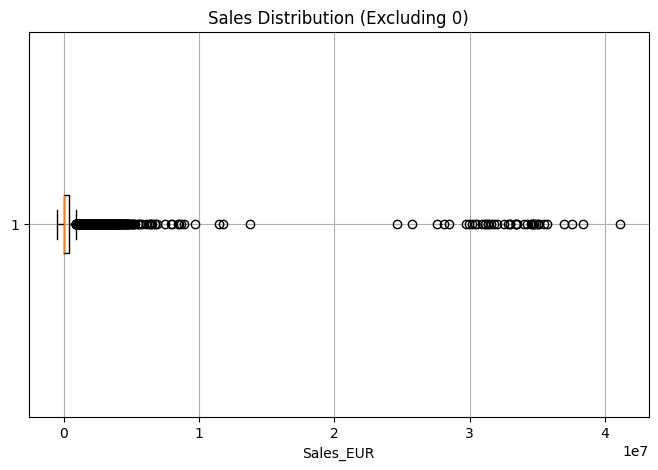

In [104]:
# Exclude 0 values
filtered_sales = sales_data[sales_data["Sales_EUR"] != 0]["Sales_EUR"]

# Boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_sales, vert=False)
plt.title("Sales Distribution (Excluding 0)")
plt.xlabel("Sales_EUR")
plt.grid(True)
plt.show()

In [105]:
# Convert DATE column to datetime format
sales_data["DATE"] = pd.to_datetime(sales_data["DATE"], format="%d.%m.%Y")

# Check for duplicate dates
duplicate_dates = sales_data["DATE"].duplicated().sum()

# Count occurrences of each unique date
date_counts = sales_data["DATE"].value_counts().sort_index()

# Display results
print(f"Number of duplicate dates: {duplicate_dates}")
print("\nFirst 10 occurrences of dates:")
print(date_counts.head(10))

Number of duplicate dates: 8586

First 10 occurrences of dates:
DATE
2018-10-01     9
2018-10-02    10
2018-10-03     1
2018-10-04     6
2018-10-05     8
2018-10-06     1
2018-10-08     7
2018-10-09     9
2018-10-10    10
2018-10-11     8
Name: count, dtype: int64


In [106]:
# Get unique values from the middle column (Mapped_GCK)
unique_values = sales_data["Mapped_GCK"].unique()

# Count the number of unique values
num_unique_values = len(unique_values)

# Display results
print(f"Number of unique values in Mapped_GCK: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values in Mapped_GCK: 14
Unique values:
['#1' '#11' '#6' '#8' '#12' '#16' '#4' '#5' '#3' '#9' '#14' '#13' '#20'
 '#36']


In [107]:
# Count occurrences of each unique value in Mapped_GCK
mapped_gck_counts = sales_data["Mapped_GCK"].value_counts()

# Display the counts
print("Count of each unique value in Mapped_GCK:")
print(mapped_gck_counts)

# Get the total number of rows in the dataset
total_rows = len(sales_data)

# Display the total number of rows
print(f"\nTotal number of rows in the dataset: {total_rows}")


Count of each unique value in Mapped_GCK:
Mapped_GCK
#1     1179
#3     1017
#5      959
#8      944
#4      877
#12     803
#6      794
#16     765
#11     732
#13     441
#36     434
#9      333
#20     293
#14     231
Name: count, dtype: int64

Total number of rows in the dataset: 9802


In [108]:
# Count duplicate DATEs for each unique Mapped_GCK
duplicates_by_gck = sales_data.groupby("Mapped_GCK")["DATE"].apply(lambda x: x.duplicated().sum())

# Display results
print("Duplicate DATEs per Mapped_GCK:")
print(duplicates_by_gck)

Duplicate DATEs per Mapped_GCK:
Mapped_GCK
#1     0
#11    0
#12    0
#13    0
#14    0
#16    0
#20    0
#3     0
#36    0
#4     0
#5     0
#6     0
#8     0
#9     0
Name: DATE, dtype: int64


In [ ]:
sales_data["Weekday"] = sales_data["DATE"].dt.day_name()
sales_data["Year"] = sales_data["DATE"].dt.year
sales_data["Month"] = sales_data["DATE"].dt.month
weekday_sales = sales_data.groupby("Weekday")["Sales_EUR"].mean().sort_values()
month_sales = sales_data.groupby("Month")["Sales_EUR"].mean().sort_values()
year_sales = sales_data.groupby("Year")["Sales_EUR"].mean().sort_values()


In [110]:
print(weekday_sales)

Weekday
Saturday     173832.675192
Sunday       191665.814371
Tuesday      200995.492794
Wednesday    212515.561120
Thursday     221827.190011
Monday       347070.474352
Friday       403934.651971
Name: Sales_EUR, dtype: float64


In [111]:
print(month_sales)

Month
1     223989.702222
11    243629.551351
7     254406.813097
10    259941.360515
3     273163.379773
5     273221.225225
6     282490.542569
2     285487.939220
8     288530.137681
4     293675.887078
12    297922.155529
9     311129.041892
Name: Sales_EUR, dtype: float64


In [112]:
print(year_sales)

Year
2018    221508.560250
2020    265281.977690
2019    277406.693069
2021    279945.056481
2022    296520.236872
Name: Sales_EUR, dtype: float64


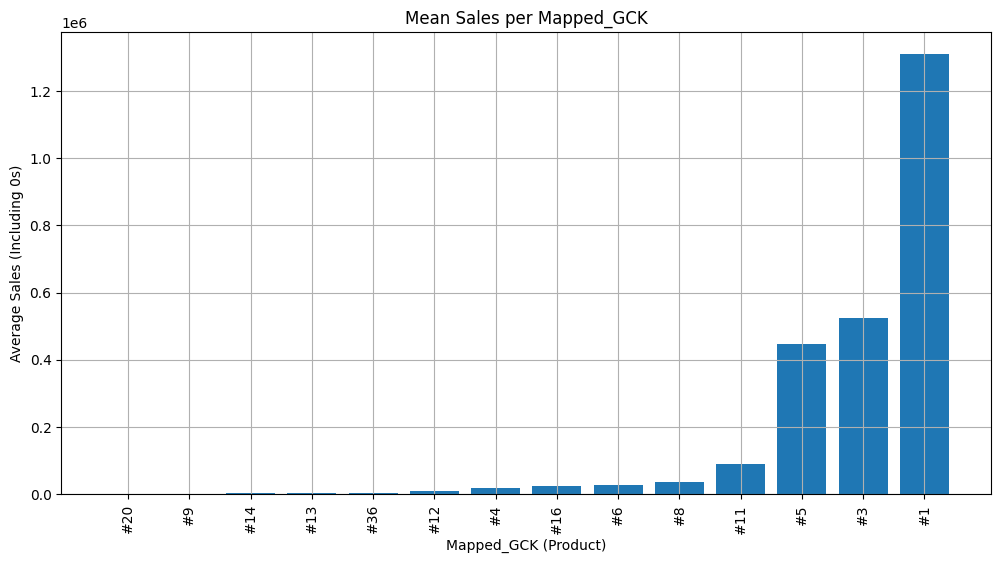

In [119]:
# Calculate mean sales per Mapped_GCK
mapped_gck_means = sales_data.groupby("Mapped_GCK")["Sales_EUR"].mean().sort_values()

# Plot the mean sales values for each product
plt.figure(figsize=(12, 6))
plt.bar(mapped_gck_means.index, mapped_gck_means.values)
plt.xticks(rotation=90)
plt.xlabel("Mapped_GCK (Product)")
plt.ylabel("Average Sales (Including 0s)")
plt.title("Mean Sales per Mapped_GCK")
plt.grid(True)
plt.show()

In [122]:
# Calculate mean sales per Mapped_GCK (Including 0s)
mapped_gck_means = sales_data.groupby("Mapped_GCK")["Sales_EUR"].mean().sort_values()

# Display the values
print("Mean Sales per Mapped_GCK (Including 0s):")
print(mapped_gck_means)


Mean Sales per Mapped_GCK (Including 0s):
Mapped_GCK
#20    2.672628e+02
#9     9.262072e+02
#14    2.137714e+03
#13    2.288236e+03
#36    2.300864e+03
#12    1.031065e+04
#4     1.781884e+04
#16    2.404064e+04
#6     2.599726e+04
#8     3.693975e+04
#11    9.002908e+04
#5     4.479615e+05
#3     5.245265e+05
#1     1.309759e+06
Name: Sales_EUR, dtype: float64


Probably important variables from the sales data:

- Year: Shows an upward trend;
- Month: There are monthly functuations;
- Mapped_GCK: Different products have

### Market Data Analysis

In [123]:
market_data.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,NaN,China,China,France,France,Germany,Germany,Italy,Italy,Japan,Japan,Switzerland,Switzerland,United Kingdom,United Kingdom,United States,United States,Europe,Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Producer Prices,Producer Prices,Producer Prices,Producer Prices,Producer Prices,Producer Prices,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index
1,Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,World: Price of Base Metals,World: Price of Energy,World: Price of Metals & Minerals,World: Price of Natural gas index,"World: Price of Crude oil, average",World: Price of Copper,United States: EUR in LCU,United States: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment,China: Electrical equipment,United States: Machinery and equipment n.e.c.,World: Machinery and equipment n.e.c.,Switzerland: Machinery and equipment n.e.c.,United Kingdom: Machinery and equipment n.e.c.,Italy: Machinery and equipment n.e.c.,Japan: Machinery and equipment n.e.c.,France: Machinery and equipment n.e.c.,Germany: Machinery and equipment n.e.c.,United States: Electrical equipment,World: Electrical equipment,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment
2,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
3,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,91.221862,89.987275,111.353812,73.601265,107.6014,79.24023,97.122911,80.09853,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.1,106.191977,116.790276,110.890034,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
4,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.62748,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,1

In [124]:
# Remover a linha 2 (índice 2, pois Python começa em 0)
market_data = market_data.drop(index=2).reset_index(drop=True)

# Criar novos nomes de colunas juntando Cell 0 e Cell 1 com " - ", exceto onde Cell 0 for NaN
new_columns = [
    f"{market_data.iloc[0, i]} - {market_data.iloc[1, i]}" if pd.notna(market_data.iloc[0, i]) 
    else market_data.iloc[1, i] 
    for i in range(market_data.shape[1])
]

# Aplicar os novos nomes às colunas
market_data.columns = new_columns

# Remover as duas primeiras linhas, já que agora fazem parte do header
market_data = market_data.iloc[2:].reset_index(drop=True)

# Renomear a primeira coluna para "Date"
market_data = market_data.rename(columns={market_data.columns[0]: "Date"})

In [135]:
# Remover espaços em branco da coluna Date
market_data["Date"] = market_data["Date"].str.strip()

# Criar coluna Year extraindo os primeiros 4 caracteres
market_data["Year"] = market_data["Date"].str[:4].astype(int)

# Criar coluna Month removendo o 'm' e convertendo para inteiro
market_data["Month"] = market_data["Date"].str[5:].astype(int)


In [ ]:
# Contagem de ocorrências para Year
year_counts = market_data["Year"].value_counts().sort_index()

# Contagem de ocorrências para Month
month_counts = market_data["Month"].value_counts().sort_index()

# Mostrar os resultados
print("Unique Years and Counts:")
print(year_counts)

print("\nUnique Months and Counts:")
print(month_counts)



Unique Months and Counts:
Month
1     18
2     19
3     19
4     19
5     18
6     18
7     18
8     18
9     18
10    18
11    18
12    18
Name: count, dtype: int64


In [139]:
market_data.head(5)

,Date,China - Production Index Machinery & Electricals,China - Shipments Index Machinery & Electricals,France - Production Index Machinery & Electricals,France - Shipments Index Machinery & Electricals,Germany - Production Index Machinery & Electricals,Germany - Shipments Index Machinery & Electricals,Italy - Production Index Machinery & Electricals,Italy - Shipments Index Machinery & Electricals,Japan - Production Index Machinery & Electricals,Japan - Shipments Index Machinery & Electricals,Switzerland - Production Index Machinery & Electricals,Switzerland - Shipments Index Machinery & Electricals,United Kingdom - Production Index Machinery & Electricals,United Kingdom - Shipments Index Machinery & Electricals,United States - Production Index Machinery & Electricals,United States - Shipments Index Machinery & Electricals,Europe - Production Index Machinery & Electricals,Europe - Shipments Index Machinery & Electricals,World: Price of Base Metals,World: Price of Energy,World: Price of Metals & Minerals,World: Price of Natural gas index,"World: Price of Crude oil, average",World: Price of Copper,United States: EUR in LCU,Producer Prices - United States: Electrical equipment,Producer Prices - United Kingdom: Electrical equipment,Producer Prices - Italy: Electrical equipment,Producer Prices - France: Electrical equipment,Producer Prices - Germany: Electrical equipment,Producer Prices - China: Electrical equipment,production index - United States: Machinery and equipment n.e.c.,production index - World: Machinery and equipment n.e.c.,production index - Switzerland: Machinery and equipment n.e.c.,production index - United Kingdom: Machinery and equipment n.e.c.,production index - Italy: Machinery and equipment n.e.c.,production index - Japan: Machinery and equipment n.e.c.,production index - France: Machinery and equipment n.e.c.,production index - Germany: Machinery and equipment n.e.c.,production index - United States: Electrical equipment,production index - World: Electrical equipment,production index - Switzerland: Electrical equipment,production index - United Kingdom: Electrical equipment,production index - Italy: Electrical equipment,production index - Japan: Electrical equipment,production index - France: Electrical equipment,production index - Germany: Electrical equipment,Year,Month
0,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,91.221862,89.987275,111.353812,73.601265,107.6014,79.24023,97.122911,80.09853,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.1,106.191977,116.790276,110.890034,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132,2004,2
1,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.62748,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815,2004,3
2,2004m4,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,85.622508,79.740802,108.732297,73.026027,108.166564,89.774031,101.715199,85.167236,54.872715,47.779013,49.423751,91.379923,42.650637,39.134854,1.1985,80.337639,80.757423,93.852425,NaN,93.440903,NaN,103.484955,100.16909,93.793535,104.965505,125.289566,105.648765,125.482231,90.961426,117.441124,NaN,71.552403,115.55733,137.796875,106.271197,105.335777,87.253983,2004,4
3,2004m5,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,85.378729,79.598021,110.6452,74.591883,108.425887,87.463813,101.275727,84.485767,51.230356,53.590898,46.468392,99.04452,47.51712

## Selection of Key Macroeconomic Variables

Based on our analysis and discretion, we believe that the following variables are the most important for predicting Siemens' monthly sales (`Sales_EUR`). These variables were selected to balance **demand-side factors, cost influences, and production constraints**, while following the expert advice of using **fewer but high-value features**.

### **Production and Shipment Indices**
- **China - Production Index Machinery & Electricals**  
  Reflects industrial production levels in one of Siemens' largest client markets. A higher production index suggests increased demand for machinery and electrical equipment, potentially leading to higher sales.
- **United States - Production Index Machinery & Electricals**  
  Measures industrial production in Siemens' most important client country. An expansion in this index indicates higher demand for Siemens' products in the US.
- **Germany - Production Index Machinery & Electricals**  
  Since the sales data originates from a German branch, local industrial activity may directly influence Siemens' sales. This index tracks production in Germany's machinery sector.
- **China - Shipments Index Machinery & Electricals**  
  Tracks the shipment volume of machinery and electrical equipment from China. A higher shipment index suggests increased exports, which could indicate greater demand for Siemens' products.
- **United States - Shipments Index Machinery & Electricals**  
  Measures the volume of shipments in the US, an indicator of how much industrial equipment is moving through the supply chain. Increased shipments could signal strong demand.
- **Germany - Shipments Index Machinery & Electricals**  
  Represents the shipment levels of machinery and electrical products in Germany. As a domestic market for Siemens, this index provides insight into national demand.

### **Producer Prices (Cost of Siemens' Industrial Goods)**
- **Producer Prices - United States: Electrical Equipment**  
  Indicates how expensive electrical equipment is for Siemens' US-based clients. Rising producer prices may reduce purchasing power, while lower prices could stimulate demand.
- **Producer Prices - China: Electrical Equipment**  
  Represents the cost of electrical equipment in China, which could influence both Siemens' costs and its pricing strategies.
- **Producer Prices - Germany: Electrical Equipment**  
  Since Siemens' sales data comes from a German branch, fluctuations in local producer prices could impact profitability and sales volume.

### **Raw Material and Energy Costs**
- **World: Price of Base Metals**  
  Siemens' industrial products rely on metals such as steel and aluminum. A rise in metal prices increases production costs, potentially impacting sales and margins.
- **World: Price of Energy**  
  Higher energy costs can raise manufacturing expenses, affecting both Siemens' pricing strategies and overall industrial activity.
- **World: Price of Crude Oil, Average**  
  Oil prices influence transportation and supply chain costs. A significant rise in crude oil prices could slow industrial investment and impact Siemens' sales.
- **World: Price of Copper**  
  Copper is a critical raw material for electrical equipment manufacturing. Its price fluctuations can affect Siemens' production costs and pricing decisions.

These selected variables cover both **demand-side** factors (production and shipments), **cost structures** (producer prices), and **macro-level influences** (raw material and energy prices). This approach ensures a balanced, minimal, and high-impact feature selection.


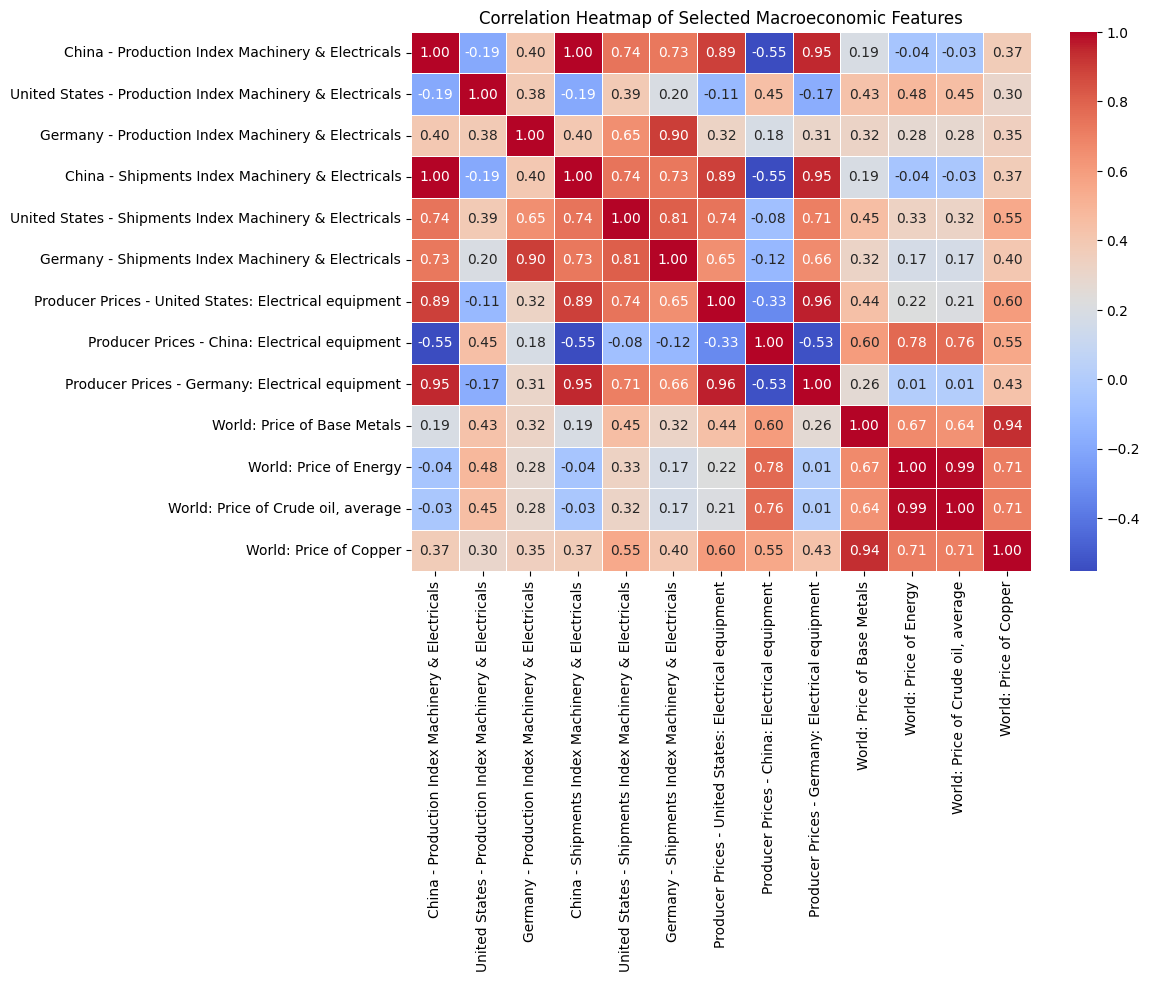

In [146]:
# Define the selected macroeconomic features
macro_features = [
    "China - Production Index Machinery & Electricals",
    "United States - Production Index Machinery & Electricals",
    "Germany - Production Index Machinery & Electricals",
    "China - Shipments Index Machinery & Electricals",
    "United States - Shipments Index Machinery & Electricals",
    "Germany - Shipments Index Machinery & Electricals",
    "Producer Prices - United States: Electrical equipment",
    "Producer Prices - China: Electrical equipment",
    "Producer Prices - Germany: Electrical equipment",
    "World: Price of Base Metals",
    "World: Price of Energy",
    "World: Price of Crude oil, average",
    "World: Price of Copper"
]

# Compute the correlation matrix for only the selected features
correlation_matrix = market_data[macro_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Macroeconomic Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Feature Selection Strategy

### **Overview**
The goal of this process is to select the most valuable macroeconomic indicators for forecasting Siemens' monthly sales while avoiding redundancy. Instead of using many similar features, we focus on a **minimal but high-impact set** that captures the key economic drivers influencing Siemens' business.

### **1️⃣ Consolidating Redundant Features**
#### **China - Production Index Machinery & Electricals**
This variable exhibits **very high correlation** with multiple other features:
- **1.00** with `China - Shipments Index Machinery & Electricals`
- **0.74** with `United States - Shipments Index Machinery & Electricals`
- **0.73** with `Germany - Shipments Index Machinery & Electricals`
- **0.89** with `Producer Prices - United States: Electrical Equipment`
- **0.95** with `Producer Prices - Germany: Electrical Equipment`

Given this extreme correlation, we will **retain "China - Production Index Machinery & Electricals" as a representative variable**, allowing it to encapsulate the information from these **six** highly correlated features. This reduces feature redundancy while ensuring we maintain predictive power.


### **2️⃣ Aggregating World Price Features**
- **World: Price of Base Metals**  
- **World: Price of Energy**  
- **World: Price of Crude Oil, Average**  
- **World: Price of Copper**  

Our decision to merge these indicators was based on their **high correlation**. Siemens’ industrial equipment production and sales are influenced by both **raw material costs (Base Metals and Copper)** and **energy costs (Energy & Crude Oil)**:
- **Metals (Base Metals & Copper):** Essential raw materials for electrical and industrial components, impacting Siemens’ production costs and pricing strategies.
- **Energy (Energy & Crude Oil):** Affects Siemens' manufacturing processes and global supply chains, as energy-intensive industries depend on stable prices.

### **3️⃣ Removing Weakly Correlated Features**
The remaining three features:
- `Producer Prices - China: Electrical Equipment`
- `United States - Production Index Machinery & Electricals`
- `Germany - Production Index Machinery & Electricals`

show some moderate correlations. Their effects will already be reflected in the merged features, so we **exclude them** to keep the model clean and efficient.


### **Conclusion**
This selection **keeps the most important economic drivers** while reducing unnecessary complexity. It ensures that **industrial production, pricing trends, and supply costs** are represented in a minimal but effective way.


Create the "World: Aggregated Price Index" 

In [ ]:
market_data["World: Aggregated Price Index"] = (
    market_data["World: Price of Base Metals"] +
    market_data["World: Price of Energy"] +
    market_data["World: Price of Crude oil, average"] +
    market_data["World: Price of Copper"]
) / 4
